<a href="https://colab.research.google.com/github/pjmartel/ChEEQ_tool/blob/main/ChEEQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ChEEQ:** **Ch**icken **E**mbryo **E**longation **Q**uantification tool

<img src="https://github.com/pjmartel/embryo_tool/blob/main/Figure1.png?raw=true" align ="left" alt="drawing" hspace="20" width="400"/>

<h3>ChEEQ is an open-source computational tool with the purpose of allowing a user-friendly analysis of quantitative data acquired from length measurements of developing chicken embryos. This tool allows:</h3>

<ul>
  &nbsp;<h3>1. Visualization and exploration of data obtained from time-lapse imaging experiments of chicken embryos from HH4 to HH10 (<i>Hamburger and Hamilton, J Morphol 1951</i>)</h3>
   &nbsp;<h3>2. Visualization and analysis of your own experimental data (static images or live-imaging).</h3>
</ul>
For more information and/or to cite this tool, please refer to the original manuscript: <i>Maia-Fernandes et al., Dev Biol</i> (submitted)
</p>

---
# First, please take the following steps to get the program going!

## Initialize the code

In [1]:
#@title  Press play button to initialize
# Import modules
from google.colab import files
from IPython.display import display, Markdown, clear_output
from ipywidgets import Button, Layout, Dropdown, Output, VBox, HBox
import numpy as np
from matplotlib import pyplot as plt, style
#style.use('seaborn-darkgrid')
style.use('ggplot')
import seaborn as sb
import pandas as pd
from google.colab import auth
from scipy.stats import linregress
import gspread
from oauth2client.client import GoogleCredentials
from warnings import filterwarnings
filterwarnings("ignore")

##
def linreg_interval(x,y,interval=0.95):
  """
  Linear regression with confidence intervals.
  """
  import numpy as np
  from scipy.stats import t

  def sdmean(p):
    """
    Computes the sum square devation from the mean.
    """
    return np.var(p,ddof=0)*len(p)

  def SSD(p,q):
    """
    Computes the sum of squares deviation between two data vectors.
    """
    return ((p-q)**2).sum()

  N = len(x)
  mhat, bhat = np.polyfit(x,y,deg=1)
  yhat = x*mhat + bhat
  resi = SSD(y,yhat)

  gamma = 1-interval
  SDM = sdmean(x)
  sem = np.sqrt(resi/(N-2)/SDM)
  seb = sem*np.sqrt((x**2).mean())
  tval = t.ppf(1-gamma/2,df=N-2)
  return mhat, bhat, 1-resi/sdmean(y), np.corrcoef(x,y)[0,1],\
        (mhat-sem*tval, mhat+sem*tval), (bhat-seb*tval, bhat+seb*tval)

##
def read_data(gc_auth, spreadsheet, worksheet="", list=False):

  try:
    s = gc_auth.open(spreadsheet)
  except:
    print(f"Spreadsheet file '{spreadsheet}' not found in google drive.")
    return None

  ws_list = [s.title for s in gc.open(spreadsheet).worksheets()]
  if list:
    print(ws_list)
    return
  if worksheet not in ws_list:
    print(f"The worksheet '{worksheet}' is not part of '{spreadsheet}'")
    return None
  else:
    w = gc.open(spreadsheet).worksheets()[ws_list.index(worksheet)]
    rows = w.get_all_values()
    # Pop the top row containting the headers
    headers = rows.pop(0)
    print(f"The worksheeet '{worksheet}' contains the following headers:")
    print(headers)
    # Create a data frame from the row list, usaing
    # the sheet header as column labels.
    df = pd.DataFrame.from_records(rows, columns=headers)
    print(f"reading a {df.shape} worksheet table into a dataframe")
    return df

## C-pPL	C-PS	C-N	N-pPL	PS	PSM	C-Seg	Seg	C-HF	HHStage	Embryo	CultureType
def clean_data(df):

  # Data Labels
  labels_num = ['Time', 'C-pPL', 'C-PS', 'C-N', 'N-pPL', 'N-PS', 'PSM',
             'C-Seg', 'SEG', 'C-HF', 'HHStage']
  labels_txt = ['Embryo', 'CultureType']
  type_dict = dict.fromkeys(labels_num,'float32')
  type_dict.update(dict.fromkeys(labels_txt,'str'))
  # Replace null strings by nan
  df.replace('', np.nan,inplace=True)
  # Convert decimal commas to points
  df.replace(to_replace=r'([0-9]),([0-9])',
             value=r'\1.\2',
             regex=True,
             inplace=True)
  #data_ref.shape
  df = df.astype(type_dict)

  df.dropna(axis='index',how='all',subset=labels_num[1:-1],inplace=True)
  print(f"After cleaning, the new data frame size is {df.shape}")
  return df

##
def regplot_with_bands(ax, x_var, y_var, data, sigma=3.0, color=None, label=True,
                       sigma_bands=True, scatter=True, limits=False, lb_prefix="", **kwargs):

  from seaborn import regplot
  from scipy.stats import linregress
  import numpy as np

  marker = '^'
  data_clean = data[[x_var, y_var]].dropna(axis=0, how='any')
  x = np.array(data_clean[x_var])
  y = np.array(data_clean[y_var])
  p = np.argsort(x)
  x = x[p]
  y = y[p]
  m, b, r, _, _ = linregress(x, y)
  # calc variance of data
  y_hat = m * x + b
  yy = y - y_hat
  yy_var = yy.var(ddof=2)
  yy_std = np.sqrt(yy_var)
  if sigma_bands:
    ax.plot(x, y_hat + sigma*yy_std,'g--')
    ax.plot(x, y_hat - sigma*yy_std,'g--')
  if label:
    label = f"{y_var}: m={m:5.3f} b={b:5.3f}  r2={r*r:5.3f} -- var={yy_var:6.4f}"
    label = lb_prefix + label
  else:
    label = None
  if limits:
    ax.set_xlim(min(x),max(x))
  regplot(x=x_var, y=y_var, data=data_clean, label=label,
          color=color, scatter=scatter, ax=ax, marker=marker, **kwargs)
  return label, m, b, r, yy_var

def export_button(fig, name):
  def on_button_clicked(_):
    fig.savefig(name, bbox_inches='tight')
    files.download(name)

  button = Button(description='Export plot to PDF')
  button.on_click(on_button_clicked)
# displaying button and its output together
  display(button)


class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# Print colored text using markdown mode
from IPython.display import Markdown, display
def printmd(string, color="#BBBBBB"):
    colorstr = "<font color='{}'>{}</font>".format(color, string)
    display(Markdown(colorstr))

# Flags
set_manual_obervations = False #user has not input manual points

## Read sample data files from Github

In [2]:
#@title Press play button to read Excel file with sample data from Github repository
#from google.colab import drive
#drive.mount('/gdrive')

# Read data file from Github
_ = !curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://api.github.com/repos/pjmartel/embryo_tool/contents/ChEEQ_inputData.xlsx
# Read image file from Github
_ = !curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://api.github.com/repos/pjmartel/embryo_tool/contents/measurements_color.png

In [3]:
#@title  Press play button to read worksheets from the Excel data file
df = pd.read_excel("/content/ChEEQ_inputData.xlsx", sheet_name=None)

print("The excel workbook contains the following sheets:\n")
print(*df.keys(), sep=", ")
print()
print()

sheets_to_read = ['ALLRaw_DATA', 'Experiments_SingleObservations', 'Experiments_ObservationsOverTim']
data_ref = df["REF_DATA"]
print("REF_DATA: ", end="")
data_ref = clean_data(data_ref)
print()
data_xper_single = df["Experiments_SingleObservations"]
print("Experiments_SingleObservations: ", end="")
data_xper_single = clean_data(data_xper_single)
print()
data_xper_multi = df["Experiments_ObservationsOverTim"]
print("Experiments_ObservationsOverTim: ", end="")
data_xper_multi = clean_data(data_xper_multi)


The excel workbook contains the following sheets:

REF_DATA, Experiments_SingleObservations, Experiments_ObservationsOverTim


REF_DATA: After cleaning, the new data frame size is (390, 14)

Experiments_SingleObservations: After cleaning, the new data frame size is (28, 14)

Experiments_ObservationsOverTim: After cleaning, the new data frame size is (30, 14)


---
# All done! Feel free to explore the **Early Chicken Embryo Elongation Data (HH4 - HH10)**

##  Raw data visualization of WT embryos, optionally with linear regression
Plots of all or individual measurements against time or measurements C-N or C-HF, optionally fitted with a linear regression model. Confidence intervals for the regression parameters are computed assuming the chosen confidence level. For individual measurements, points can be colored by embryo.

Button(description='Export plot to PDF', style=ButtonStyle())

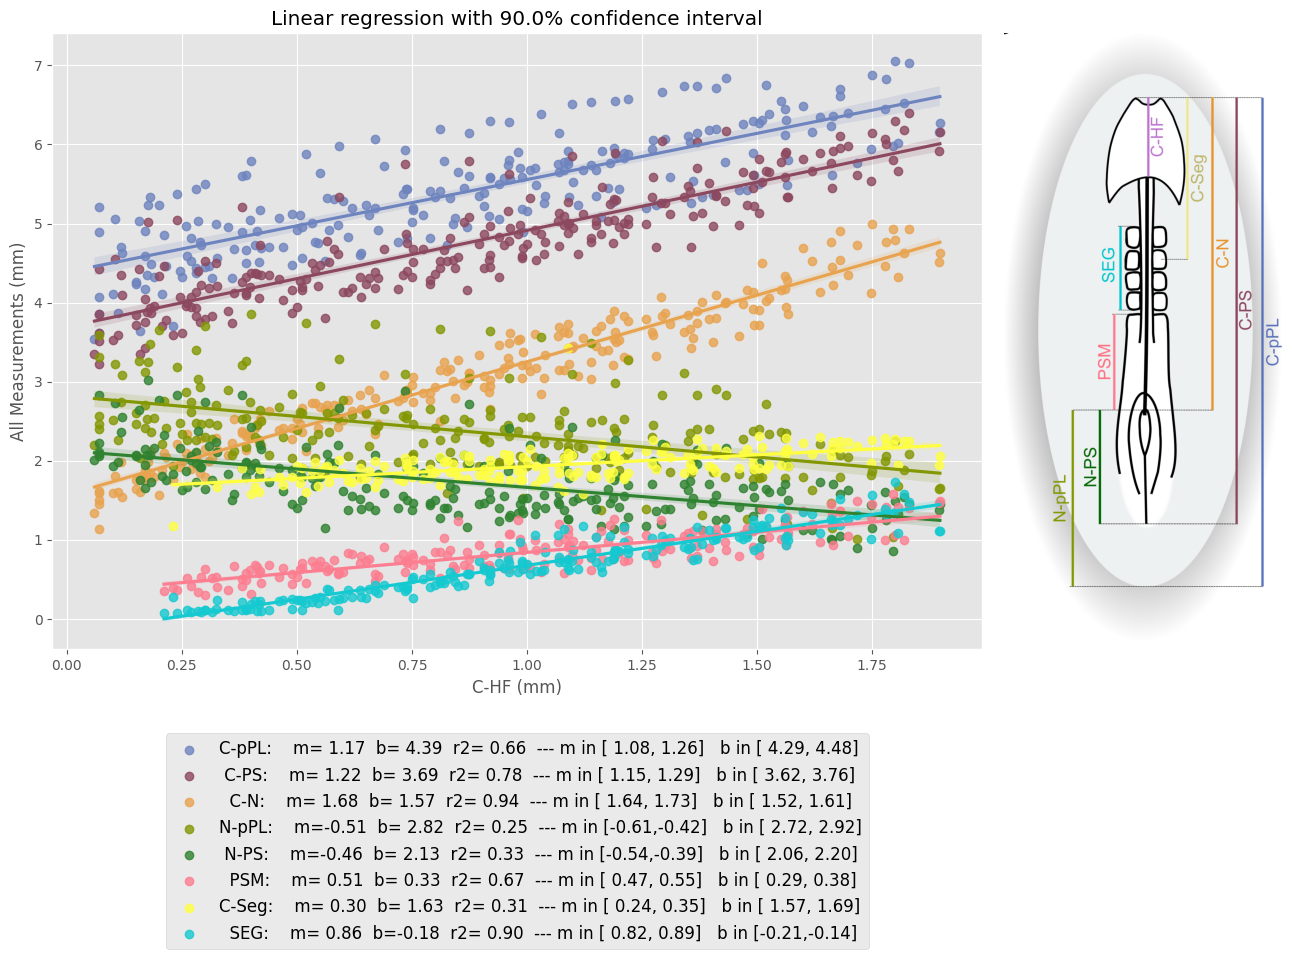

In [5]:
#@title {run: "auto"}
from matplotlib.font_manager import FontProperties
from matplotlib.colors import to_rgb
fontP = FontProperties()
fontP.set_size('large')
fig, ax = plt.subplots(figsize=(12,8))
fig.set_facecolor("white")
all_measures = ['C-pPL', 'C-PS', 'C-N', 'N-pPL', 'N-PS', 'PSM',
               'C-Seg', 'SEG', 'C-HF']


color_dict = {'C-pPL' : "#6e84bf",
              'C-PS'  : "#8c485f",
              'C-N'   : "#e8a34f",
              'N-pPL' : "#839702",
              'N-PS'  : "#2f8230",
              'PSM'   : "#fc7e90",
              'C-Seg' : "#ffff40", #"#efe79d"
              'SEG'   : "#15c9d0",
              'C-HF'  : "#c381d3" }

color_dict = { k : to_rgb(v) for k, v in color_dict.items()}

x_measure = 'C-HF' #@param ['C-N','C-HF', 'Time','HHStage']
y_measure = 'all' #@param ['all', 'C-pPL', 'C-PS', 'C-N', 'N-pPL', 'N-PS', 'PSM', 'C-Seg', 'SEG', 'C-HF']
measures = all_measures if y_measure == 'all' else [y_measure]
color_by_embryo = False # @param {type:"boolean"}
regression_lines  = True # @param {type:"boolean"}
fit_reg = regression_lines
confidence_interval = "0.9" #@param [ 0.90, 0.95, 0.99]
confidence_interval = eval(confidence_interval)
normalize_by = 'Nothing' #@param ['Nothing', 'C-pPL', 'C-PS', 'SEG', 'C-HF']
normalize_by = False if normalize_by == 'Nothing' else normalize_by
#print(normalize_by)
#raise(StopExecution)

# For color by embryo, the figure handler is generated later
if not color_by_embryo:
  export_button(fig,"linear_confidence.pdf")

if x_measure == y_measure:
  printmd("Can't have the same measure on both axes.",color="#FF7575")
  printmd("Please change one or both measures.",color="#FF7575")
  plt.close(fig)
  raise(StopExecution)

#ax.set_title(f"Linear regression with {confidence_interval:.1%} confidence interval")
for c in measures:
  if x_measure == c:
    continue

  if normalize_by:
    print("Normalizing by", normalize_by)
    temp_data = data_ref[[x_measure, c, normalize_by]].copy()
    temp_data = temp_data.T.drop_duplicates().T #remove duplicate columns, incase x_measure is the same as normalize_by
    #temp_data.columns.values[-1] = 'normalizer'
    temp_data.dropna(axis=0, how='any', inplace=True)
    temp_data[c] /= temp_data[normalize_by]
  else:
    temp_data = data_ref[[x_measure, c]].copy()
    temp_data.dropna(axis=0, how='any', inplace=True)

  m, b, r, _, _ = linregress(temp_data[x_measure], temp_data[c])
  _, _, _, _, m_int, b_int = linreg_interval(temp_data[x_measure],
                                             temp_data[c],
                                             confidence_interval)
  label = f"{c:>5}:    m={m:5.2f}  b={b:5.2f}  r2={r*r:5.2f}"
  label = label + "  --- m in [{:5.2f},{:5.2f}]   b in [{:5.2f},{:5.2f}]".format(*m_int,*b_int)
  if color_by_embryo:
    plt.close(fig)
    if len(measures) != 1:
      printmd("Color by embryo is only available for single measurements.",color="#FF7575")
      raise(StopExecution)

    plt.close(fig)
    g=sb.lmplot(x=x_measure, y=c, data=data_ref, hue="Embryo", fit_reg=False)
    sb.move_legend(g, "center left", title='Embryo')
    fig = plt.gcf()
    # Pass the right fig handle to the print button
    export_button(fig,"linear_confidence.pdf")
    ax = g.ax
    fig.set_size_inches(12,8)
    sb.regplot(ax=ax, x=x_measure, y=c, data=data_ref, label=label, fit_reg=fit_reg, scatter=False)
    if fit_reg:
      ax.legend([label], bbox_to_anchor=(0.5, -0.15), loc=('lower center'))

  else: # don't color by embryo
    sb.regplot(color=color_dict[c],
               ax=ax, x=x_measure,
               y=c,data=temp_data,
               #y=c,data=data_ref,
               label=label,
               fit_reg=fit_reg)

if fit_reg:
  ax.set_title(f"Linear regression with {confidence_interval:.1%} confidence interval")

#_ = ax.legend(bbox_to_anchor=(1,0.65))
if y_measure == 'all':
  y_label = "All Measurements (mm)"
else:
  #y_label = y_measure + " (mm)"
  y_label = y_measure + (" (mm)" if not normalize_by else f" (normalized by {normalize_by})")
_ = ax.set_ylabel(y_label)
if x_measure == 'Time':
  _ = ax.set_xlabel(ax.get_xlabel()+" (hours)")
elif x_measure != 'HHStage':
  _ = ax.set_xlabel(ax.get_xlabel()+" (mm)")
else:
  from matplotlib.ticker import MultipleLocator
  ax.xaxis.set_major_locator(MultipleLocator(1))
  _ = ax.set_xlabel(ax.get_xlabel()+"")


if fit_reg and not color_by_embryo :
#if not color_by_embryo:
  x_offset = -0.5 if y_measure == 'all' else -0.2
#  _ = ax.legend(bbox_to_anchor=(1.,0.5), loc=('center left'),prop=fontP)
  _ = ax.legend(bbox_to_anchor=(0.5, x_offset), loc=('lower center'),prop=fontP)

# Add measurement image to axes
im = plt.imread('measurements_color.png')
newax = fig.add_axes([0.0, 0.12, 1.15, 0.76], anchor='E')
newax.imshow(im)
_ = newax.axis('off')



## Residual Plots
Residual plots for the linear fittings of measurements against time or other measurements.

Button(description='Export plot to PDF', style=ButtonStyle())

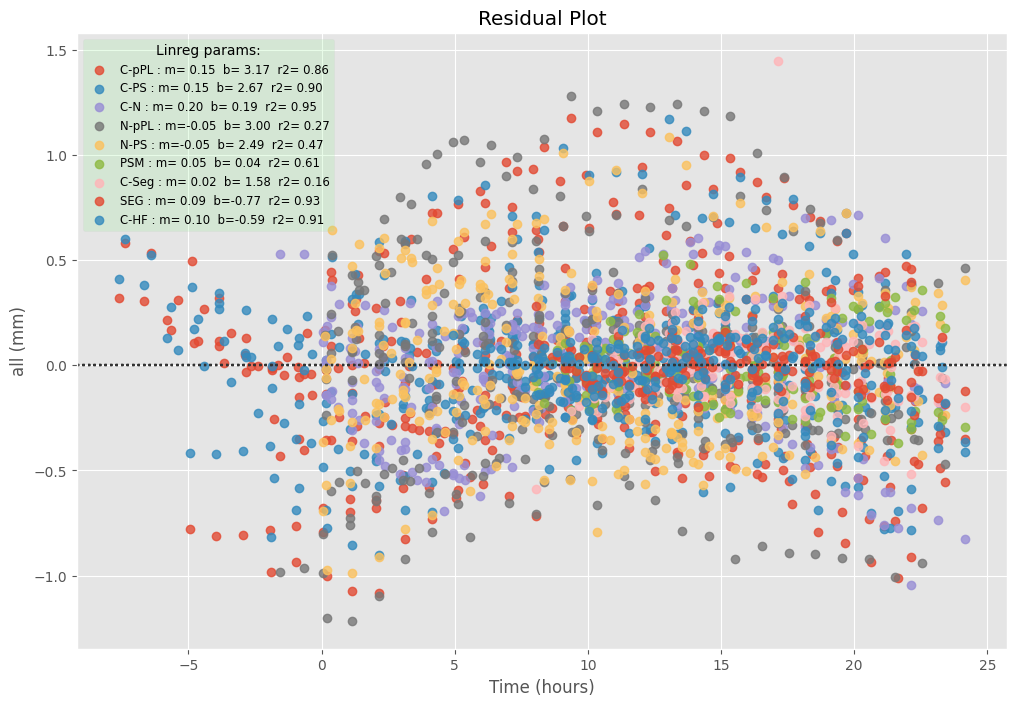

In [6]:
#@title  {run: "auto"}
fig, ax = plt.subplots(figsize=(12,8))
fig.set_facecolor('white')
export_button(fig, "residuals.pdf")
#data = data_ref.loc[:,all_measures[0]:all_measures[-1]]
all_measures = ['C-pPL', 'C-PS', 'C-N', 'N-pPL', 'N-PS', 'PSM',
               'C-Seg', 'SEG', 'C-HF']
data = data_ref

# Menus
x_measure = 'Time' #@param ['C-N', 'C-HF', 'Time']
y_measure = 'all' #@param ['all', 'C-pPL', 'C-PS', 'C-N', 'N-pPL', 'N-PS','PSM','C-Seg', 'SEG', 'C-HF']
measures = all_measures if y_measure == 'all' else [y_measure]

if x_measure == y_measure:
  print("Can't have the same measure on both axes.")
  print("Please change one or both measures.")
  plt.close(fig)
  raise(StopExecution)

for c in [m for m in measures if m!=x_measure]:
  temp_data = data[[x_measure,c]].copy()
  temp_data.dropna(axis=0, how='any', inplace=True)
  x = np.array(temp_data[x_measure])
  y = y= np.array(temp_data[c])
  p = np.argsort(x)
  x = x[p]
  y = y[p]
  m, b, r, _, _ = linregress(x, y)
  # calc variance of data
  y_hat = m * x + b
  yy = y - y_hat
  yy_var = yy.var(ddof=2)
  yy_std = np.sqrt(yy_var)
  #ax.plot(x, y_hat + 3*yy_std,'g--')
  #ax.plot(x, y_hat - 3*yy_std,'g--')
  #_, _, _, _, m_int, b_int = linreg_interval(temp_data['Med9'], temp_data[c])
  label = f" : m={m:5.2f}  b={b:5.2f}  r2={r*r:5.2f}"
  label = c + label
  #label = label + "  --- m in [{:5.2f},{:5.2f}]   b in [{:5.2f},{:5.2f}]".format(*m_int,*b_int)
  sb.residplot(x=x_measure, y=c,data=data, label=label,ax=ax)
if y_measure == 'All':
  _ = ax.set_ylabel("All Measurements (mm)")
else:
  _ = ax.set_ylabel(y_measure+" (mm)")
if x_measure == 'Time':
  ax.set_xlabel("Time (hours)")
else:
  _ = ax.set_xlabel(x_measure+" (mm)")

#  _ = ax.set_ylabel("All Measurements")
_ = ax.legend(facecolor="lightgreen",
              title="Linreg params:",
              framealpha=0.2,
              fontsize='small',
              shadow=False,
              frameon=True)
_ = ax.set_title("Residual Plot")

---
# Now test your own data against the reference measurements

## Load your own measurement data from a local spreadsheet

In [7]:
#@title Select a file from your local machine:
!rm /content/*.xlsx
uploaded = files.upload()
print(len(uploaded))
# If multiple files are uploaded, consider only the first file in list
local_xls_file = list(uploaded.keys())[0]
print(local_xls_file)
#raise(StopExecution)

df = pd.read_excel("/content/"+local_xls_file, sheet_name=None)

print("The excel workbook contains the following sheets:")
for a in df.keys():
  print(a,end=", ")
print()
print()

sheets_to_read = ['REF_DATA', 'Experiments_SingleObservations', 'Experiments_ObservationsOverTim']

print("Reading and cleaning sheets...\n")
data_ref = df["REF_DATA"]
print("REF_DATA: ", end="")
data_ref = clean_data(data_ref)
data_xper_single = df["Experiments_SingleObservations"]
print("Experiments_SingleObservations: ", end="")
data_xper_single = clean_data(data_xper_single)
data_xper_multi = df["Experiments_ObservationsOverTim"]
print("Experiments_ObservationsOverTim: ", end="")
data_xper_multi = clean_data(data_xper_multi)

Saving ChEEQ_inputData.xlsx to ChEEQ_inputData.xlsx
1
ChEEQ_inputData.xlsx
The excel workbook contains the following sheets:
REF_DATA, Experiments_SingleObservations, Experiments_ObservationsOverTim, 

Reading and cleaning sheets...

REF_DATA: After cleaning, the new data frame size is (390, 14)
Experiments_SingleObservations: After cleaning, the new data frame size is (28, 14)
Experiments_ObservationsOverTim: After cleaning, the new data frame size is (30, 14)


## Manually input data points as a series of "(x,y)" pair separated by comas (make sure to select the correct **x_measure** and **y_measure** when plotting below):
```
(x1,y1),(x2,y2),(x3,y3),...
```
(make sure to remove the example data points first)



In [8]:
observations  = (1.4, 0.5), (1.5,0.6), (1.4, 1.0)  #@param
if len(observations) == 2 and\
 not all(map(lambda x: type(x) == tuple, observations)):
 observations = (observations,)
# (4.0, 0.5), (3.5,0.65), (2.5, 0.4)
set_manual_obervations = True
print(observations)

((1.4, 0.5), (1.5, 0.6), (1.4, 1.0))


## Isolated observations, compared to reference
User data in the form of a series of points from an excel spreadsheet or manualy input (x,y) pairs of observations can be tested against the confidence bands of the reference data for the same measurement.

,CultureType,C-N,SEG,TD,TD Interval,In Interval?
0,Crtl,2.565350,0.542510,-2.535616,± 4.53,True
1,Crtl,3.987920,1.220190,-2.067450,± 4.53,True
2,Treatment1,2.081920,0.113560,-0.370889,± 4.53,True
3,Treatment1,2.519510,0.480700,-2.083108,± 4.53,True
4,Treatment1,2.222730,0.103140,0.582015,± 4.53,True
5,Treatment1,2.800510,0.612430,-1.965692,± 4.53,True
6,Treatment1,3.052460,0.526950,0.521159,± 4.53,True
7,Treatment1,3.435230,0.988430,-2.618159,± 4.53,True
8,Treatment1,3.337160,0.615340,1.167396,± 4.53,True
9,Treatment1,3.595750,0.955770,-1.288774,± 4.53,True


Button(description='Export plot to PDF', style=ButtonStyle())

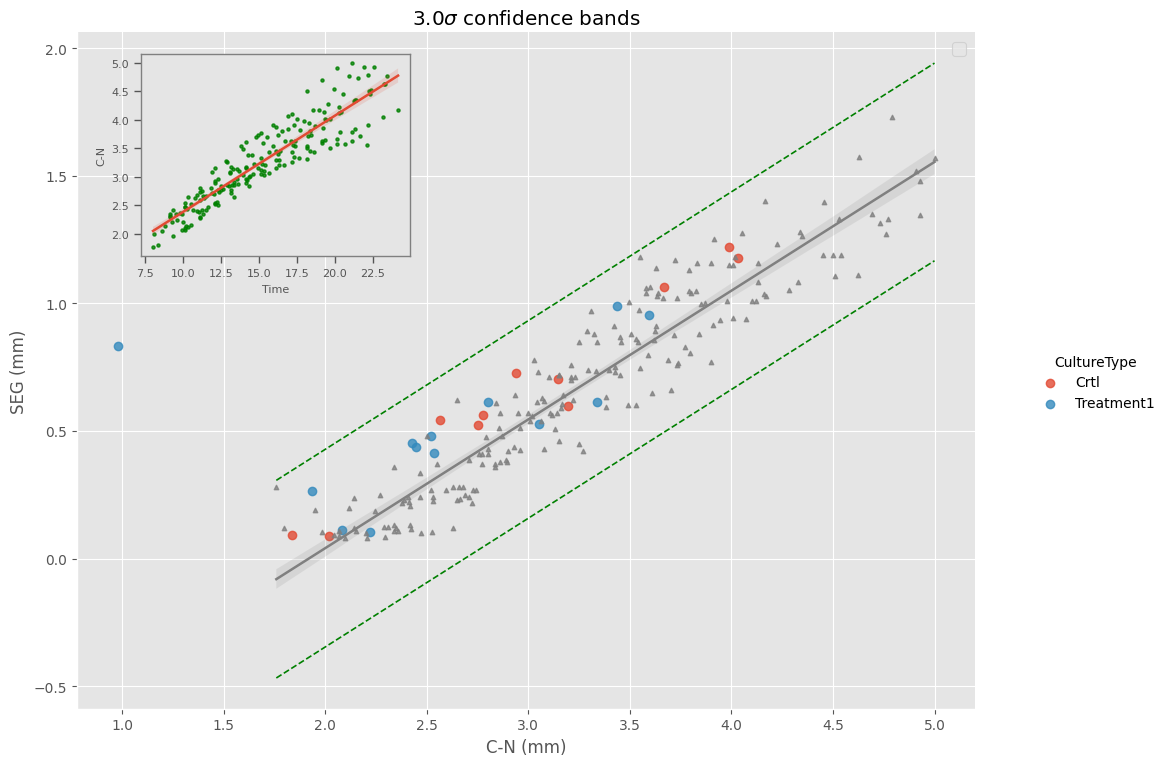

In [9]:
#@title  { run: "auto" }

# Menus
input_mode = "from file" #@param ['manual', 'from file']
color_by = "culture type" #@param ['embryo', 'culture type']
#include_zero = include_zero == "Yes"
x_measure = 'C-N' #@param ['C-N','C-HF', 'HHStage']
y_measure = 'SEG' #@param ['C-pPL', 'C-PS', 'C-N', 'N-pPL', 'N-PS', 'PSM', 'C-Seg', 'SEG', 'C-HF']
sigma_band_width = '3' #@param ['1', '2', '3', '4']
sigma = float(sigma_band_width)
time_displacement = "Yes" #@param ["Yes", "No"]
time_displacement = time_displacement == "Yes"
inset_plot = True # @param {type:"boolean"}
#@markdown ### For manual input mode, insert data in previous cell.

#
if color_by == "embryo":
  hue = "Embryo"
elif color_by == 'culture type':
  hue = "CultureType"
else:
  printmd("Invalid property for coloring data.",color="#FF7575")
  raise(StopExecution)

if x_measure == y_measure:
  printmd("Can't have the same measure on both axes.",color="#FF7575")
  printmd("Please change one or both measures.",color="#FF7575")
  raise(StopExecution)


# Check if the selected measurements are in the reference data file
missing_measures = [ a for a in (x_measure, y_measure)\
                    if a not in data_ref.columns.to_list()]
if len(missing_measures) != 0:
  printmd("The following measurement data is mmsing from the data file:", color="#FF7575")
  printmd(missing_measures, color="#FF7575")
  raise(StopExecution)

# Filter and clean reference data
data = data_ref[['Time',x_measure, y_measure]].copy()
data.dropna(axis=0, how='any', inplace=True)
time = 'Time'
# sorte values by x_measure to prevent garbled graphics
data.sort_values(by=x_measure, inplace=True)

# Lienar regressin parameters for reference data
# (a)lso compute confidence bands, based on y std error)
x = data[x_measure].to_numpy()
y = data[y_measure].to_numpy()
m, b, r, _, _ = linregress(x, y)
y_hat = m * x + b
yy = y - y_hat
yy_var = yy.var(ddof=2)
bmin = b-sigma*np.sqrt(yy_var)
bmax = b+sigma*np.sqrt(yy_var)


# Time reference linear regression
mt, bt, rt, _, _ = linregress(data[time], data[x_measure])

if input_mode == "from file":
  # clean the data
  data_single = data_xper_single[[x_measure, y_measure,'Embryo','CultureType']].copy()
  data_single.dropna(axis=0, how='any', inplace=True)

  # The smbplot is required to plot the dataframe points
  # with color according to embryo
  # Notice that lmplot creates a figure object, and not
  # an axis like regplot. So we need to run it first
  g = sb.lmplot(x=x_measure,y=y_measure, aspect=1.5,legend=True,
              data=data_single,
              hue=hue, fit_reg=False)
  ax = g.ax
  fig = plt.gcf()
  fig.set_size_inches(12,8)
  ax.set_title(f"{sigma}$\sigma$ confidence bands")

  #compute time displacements
  if time_displacement :
    x = data_single[x_measure].to_numpy()
    y = data_single[y_measure].to_numpy()
    xhat = (y-b)/m
    # NOTE: max values is calculated with bmin and vice-versa
    xhat_max = (y-bmin)/m
    xhat_min = (y-bmax)/m
    #xhat = mt*xhat_t + bt
    #xhat_t = (xhat-bt)/mt
    #disp, dispmin, dispmax = (x-xhat)/mt, (xhat-xhat_min)/mt, (xhat_max-xhat)/mt
    data_single['TD'] = (x-xhat)/mt
    data_single['TD Interval'] = (xhat-xhat_min)/mt
    data_single['TD Interval'] = data_single['TD Interval'].\
                                  map(lambda x : " ±%5.2f" % x)

    def get_interval(row):
      lower_b, upper_b = eval(row['TD Interval'])
      return (row[x_measure] > lower_b) and (row[x_measure]  < upper_b)
    def color_true_false(val):
      color = 'green' if val == True else 'red'
      return f'color: {color}'

    #data_single['In Interval?'] = data_single.apply(get_interval, axis=1)
    #data_single['xhat'] = xhat
    #data_single['xhat_min'] = xhat_min
    #data_single['xhat_max'] = xhat_max
    data_single['In Interval?'] = (x > xhat_min) & (x < xhat_max)
    ds = data_single[[hue, x_measure, y_measure, 'TD', 'TD Interval', 'In Interval?']]
    ds = ds.reset_index(drop=True)
    ds = ds.style.applymap(color_true_false, subset=['In Interval?'])
    #print(data_single[[x_measure, y_measure, 'Time Displacement',\
    #                   'TD Interval', 'In Interval?']].to_string(index=False))
    display(ds)

elif input_mode == "manual":
  if not set_manual_obervations:
    printmd("<b>Warning:</b> display of manual observations has been selected,",color="#FF7575")
    printmd("but no points have been provided as input. Using default data.<br><br>", color="#FF7575")
    observations  = (1.4,0.5), (1.5,0.6), (1.4,1.0)
  fig, ax = plt.subplots(figsize=(12,8))
  ax.set_title(f"Expected intervals for observations at {sigma} $\sigma$")
  obs_x, obs_y = zip(*observations)
  if (len(obs_x) != len(obs_y)) :
    raise "The number of x and y observations must be the same"
  if len(obs_x) * len(obs_y) == 0 :
    raise "Number of observations must be nonzero"


  from itertools import cycle
  colors = ['red', 'orange','magenta','brown','black','gray']
  iter_cl = cycle(colors)
  # Plot the observed point
  for ox, oy in zip(obs_x, obs_y) :
    if ox !=0 and oy != 0 :
      #if()
      cl = next(iter_cl)
      ax.plot(ox, oy,'*', ms=10, color=cl, label=y_measure+str((ox,oy)))
      vmax = (oy-bmin)/m
      vmin = (oy-bmax)/m
      ax.plot(vmin,oy,'o',color=cl)
      ax.plot(vmax,oy,'o',color=cl)
      ax.hlines(oy,vmin,
            vmax,
            colors=cl,
            linestyles='dashed')
      print(f"Obsevation({x_measure},{y_measure}):", ox, oy)
      print(f"For a {sigma} sigma interval, the expected",
          f"interval for {x_measure} is:",
         f"[{vmin:.4g},{vmax:.4g}]")
      if ox > vmin and ox < vmax :
        printmd(f"The {x_measure} value is within the expected interval.", color="#75FF75")
      if time_displacement:
        xhat = (oy-b)/m
        xhat_min = (oy-bmin)/m
        xhat_max = (oy-bmax)/m
        tdisp = (ox-xhat)/mt
        tdisp_min = (ox-xhat_min)/mt
        tdisp_max = (ox-xhat_max)/mt
        print(f"Time displacement: {tdisp:.3} hours [{tdisp_min:5.2f}, {tdisp_max:5.2f}]",\
              f"(± {(tdisp_max-tdisp_min)/2:5.2f} hours)")
#±
      print()

else:
  printmd(f"Invalid input mode '{input_mode}'", color="#FF7575")
  printmd(f'Exiting.', color="#FF7575")
  raise(SystemExit)


fig.set_facecolor('white')
export_button(fig, "confidence_"+input_mode+".pdf")

# Create label for regression line paramenters
label = f"{y_measure}(reference): m={m:5.2f}  b={b:5.2f}  r2={r*r:5.2f}"
label = label + f" -- var={yy_var:6.4f}"

# regplot will plot reference points and corresponding
# regression line
sb.set_context("paper",font_scale=1.5)
label, _, _, _, _ = regplot_with_bands(ax=ax, x_var=x_measure, label=False,
                                       y_var=y_measure, limits=False,
                                       data=data_ref, sigma=sigma,
                                       scatter=True,color="gray", ci=95, scatter_kws={'s':10})


# Add units to labels
x_unit = " (hours)" if x_measure=='Time' else " (mm)"
if x_measure == 'HHStage':
  from matplotlib.ticker import MultipleLocator
  ax.xaxis.set_major_locator(MultipleLocator(1))
  ax.set_xlabel(ax.get_xlabel() + "")
else:
  ax.set_xlabel(ax.get_xlabel() + x_unit)
ax.set_ylabel(ax.get_ylabel()+" (mm)")

# add inset plot for time regression
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
if time_displacement and inset_plot:
  #axi = ax.inset_axes([0.65,0.1,0.3,0.3])
  x = data[time].to_numpy()
  y = mt*x+bt

  axi = inset_axes(ax,  "30%", "30%" , bbox_to_anchor=(0.01, 0.05, 1, 1),\
                   bbox_transform=ax.transAxes, loc="upper left", borderpad=3)
  axi.spines['top'].set_edgecolor('gray')
  axi.spines['bottom'].set_edgecolor('gray')
  axi.spines['left'].set_edgecolor('gray')
  axi.spines['right'].set_edgecolor('gray')
  # Set the font size of the x and y labels
  axi.set_xlabel('X Label', fontsize=8)
  axi.set_ylabel('Y Label', fontsize=8)
  # Set the font size of the tick labels on the x and y axes
  axi.tick_params(axis='x', labelsize=8)
  axi.tick_params(axis='y', labelsize=8)
  axi.grid(False)
  axi.set_alpha(0.5)
  sb.regplot(ax=axi, x=time, y=x_measure, data=data, scatter_kws={'s':5, 'color':'green'})


#_ = sb.regplot(x=x_meas, y=y_meas, data=data_ref,ax=g.ax,color='gray', scatter_kws={'s':5})
handles, labels = plt.gca().get_legend_handles_labels()
#_ = ax.legend(['_','_','_','_', label])
if input_mode == 'manual':
  l = len(observations)
  _ = ax.legend(handles[-l:], labels[-l:])
else:
  pass
  _ = ax.legend([], [])



In [ ]:
#@title


## Observations over time, compared to reference
Compares observations of a given measurement over time,  with the reference data for the same measurement.

<font color='cyan'>+++++++++++++++++++ By Embryo : Embryo0 ++++++++++++++++++++</font>

<font color='#BBBBBB'>---- reference SEG fitting parameters: slope <b>0.857</b>, intercept <b>-0.178</b></font>

<font color='#BBBBBB'>---- this experiment fitting parameters: slope <b>0.933</b>, intercept <b>-0.266</b></font>

<font color='#BBBBBB'>---- Y-axis displacement: <font color='salmon'><b>-0.088</b></font></font>

<font color='cyan'>+++++++++++++++++++ By Embryo : Embryo1 ++++++++++++++++++++</font>

<font color='#BBBBBB'>---- reference SEG fitting parameters: slope <b>0.857</b>, intercept <b>-0.178</b></font>

<font color='#BBBBBB'>---- this experiment fitting parameters: slope <b>1.050</b>, intercept <b>-0.494</b></font>

<font color='#BBBBBB'>---- Y-axis displacement: <font color='salmon'><b>-0.317</b></font></font>

<font color='cyan'>+++++++++++++++++++ By Embryo : Embryo2 ++++++++++++++++++++</font>

<font color='#BBBBBB'>---- reference SEG fitting parameters: slope <b>0.857</b>, intercept <b>-0.178</b></font>

<font color='#BBBBBB'>---- this experiment fitting parameters: slope <b>1.003</b>, intercept <b>-0.683</b></font>

<font color='#BBBBBB'>---- Y-axis displacement: <font color='salmon'><b>-0.505</b></font></font>

<font color='cyan'>+++++++++++++++++++ By Embryo : Embryo3 ++++++++++++++++++++</font>

<font color='#BBBBBB'>---- reference SEG fitting parameters: slope <b>0.857</b>, intercept <b>-0.178</b></font>

<font color='#BBBBBB'>---- this experiment fitting parameters: slope <b>1.279</b>, intercept <b>-1.027</b></font>

<font color='#BBBBBB'>---- Y-axis displacement: <font color='salmon'><b>-0.849</b></font></font>

<font color='cyan'>+++++++++++++++++++ By Embryo : Embryo4 ++++++++++++++++++++</font>

<font color='#BBBBBB'>---- reference SEG fitting parameters: slope <b>0.857</b>, intercept <b>-0.178</b></font>

<font color='#BBBBBB'>---- this experiment fitting parameters: slope <b>1.062</b>, intercept <b>-0.351</b></font>

<font color='#BBBBBB'>---- Y-axis displacement: <font color='salmon'><b>-0.173</b></font></font>

Button(description='Export plot to PDF', style=ButtonStyle())

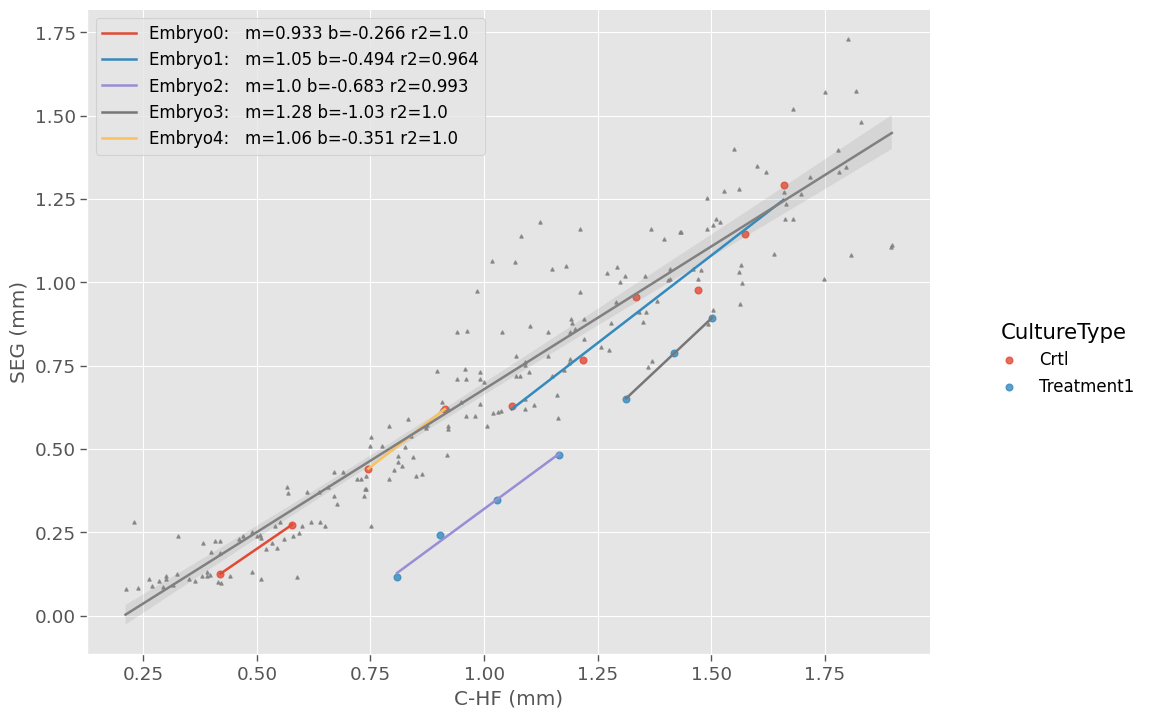

In [196]:
#@title  { run: "auto" }

# Menus
#x_measure = 'Time' #@param ['C-N', 'C-HF', 'Time']
x_measure = 'C-HF' #@param ['C-N', 'C-HF']
y_measure = 'SEG' #@param ['C-pPL', 'C-PS', 'C-N', 'N-pPL', 'N-PS', 'PSM', 'C-Seg', 'SEG', 'C-HF']
sigma = '3' #@param ['1', '2', '3', '4']
sigma = float(sigma)
display_by = 'Embryo' #@param ['CultureType', 'Embryo']
hue = display_by
sigma_bands  = False # @param {type:"boolean"}
confidence_bands = False # @param {type:"boolean"}
ci = 95 if confidence_bands else None
regression_lines = True # @param {type:"boolean"}
by_embryo_by_culture = True # @param {type:"boolean"}
legend_fontsize = 12 # @param ["8","10","12","14","16"] {"type":"raw","allow-input":true}
plt.rcParams['legend.fontsize'] = legend_fontsize
plt.rcParams['legend.title_fontsize'] = legend_fontsize * 14 / 11

if x_measure == y_measure:
  printmd("Can't have the same measure on both axes.",color="#FF7575")
  printmd("Please change one or both measures.",color="#FF7575")
  raise(StopExecution)


#temp_data = data_xper_multi[[x_measure,y_measure,hue]].dropna(axis=0, how='any')
temp_data = data_xper_multi[[x_measure,y_measure,'CultureType', 'Embryo']].dropna(axis=0, how='any')

temp_data.iloc[0,3] = 'Embryo0'
temp_data.iloc[1,3] = 'Embryo0'
temp_data.iloc[2,3] = 'Embryo4'
temp_data.iloc[3,3] = 'Embryo4'
temp_data.iloc[14,3] = 'Embryo3'
temp_data.iloc[15,3] = 'Embryo3'
temp_data.iloc[16,3] = 'Embryo3'

# Generate groups before lmplot to pass the correct hue order
groups = temp_data.groupby(hue)
hue_order = [name for (name, _) in groups]


# If by_embrio_by_culture is False, then the "hue" value is
# both to create the groups and to color the points.
# If not, colorization will be done as below:
if by_embryo_by_culture and hue == 'Embryo' :
  hue = 'CultureType'
  hue_order = list(temp_data['CultureType'].unique())

legend_artist_offeset = len(hue_order)
g = sb.lmplot(x=x_measure,y=y_measure, aspect=1.5,
              data=temp_data, legend=True,
              hue=hue, hue_order=hue_order,
              #palette=['black', 'black'],
              #markers=['o','s'],
              fit_reg=False, scatter=True, legend_out=True)
ax = g.ax


data_ref_temp = data_ref[[x_measure, y_measure]].dropna(axis=0, how='any')
m, b, r , _ , _ = linregress(data_ref_temp)

# compute linear regression of measured variable, gouping by embryo
# or culture type and plotting with regplot. The hue order is the same
# used in the scatter lmplot
labels = []
hue = groups.keys # recover the original hue value
for name, gr in groups:
  #ax.plot(g[x_measure],g[y_measure],'.-', label=name)
  #_ = plt.legend(title="Embryo")

  x = np.array(gr.iloc[:,0])
  y = np.array(gr.iloc[:,1])
  mm, bm, rm, _, _ = linregress(x, y)
  labels.append(f"{name}:   m={mm:.3} b={bm:.3} r2={rm**2:.3}")

  printmd(f" By {hue} : {name} ".center(60, "+"),color="cyan")
  printmd(f"---- reference {y_measure} fitting parameters: "+\
        f"slope <b>{m:5.3f}</b>, intercept <b>{b:5.3f}</b>")
  printmd("---- this experiment fitting parameters: "+\
        f"slope <b>{mm:5.3f}</b>, intercept <b>{bm:5.3f}</b>")
  printmd(f"---- Y-axis displacement: <font color='salmon'><b>{bm-b:5.3f}</b></font>")
  print()
  if regression_lines:
    _ = sb.regplot(x=x_measure, y=y_measure, data=gr,
               label=name, ax=ax, scatter=False, ci=ci)
    #ax.collections[0].set_label('_nolegend_')
    #ax.collections[1].set_label('_nolegend_')
    #ax.collections[2].set_label('_nolegend_')
  else:
    labels = []
  #plt.setp(ax2.collections[3], alpha=0)
#  _ = sb.regplot(x=x_meas, y=y_meas, data=data_xper_multi,
#               label="",ax=g.ax,color='blue', scatter=False)
handles = ax.get_legend_handles_labels()[0]
_ = ax.legend(handles=handles[legend_artist_offeset:], labels=labels)
#raise(StopExecution)
#
fig = plt.gcf()
fig.set_size_inches(12,8)
fig.set_facecolor('white')
export_button(fig, "obs_vs_time_comp_ref.pdf")

#legend_labels = ['_','_','_','_',label]+labels
label, m, b, r, var = regplot_with_bands(ax=ax, x_var=x_measure, y_var=y_measure, sigma=sigma, sigma_bands=sigma_bands,
                   data=data_ref, scatter=True,limits=False,color="gray",ci=95, scatter_kws={'s':5})
#legend_labels = ['_']*(len(groups)-4)+ sum([[l,'_'] for l in labels],[]) + ['_','_','_',label]
#legend_labels = [l for l in labels] # + 20*['_']
#handles, labels = plt.gca().get_legend_handles_labels()
#print(handles)
#print(labels)

#_ = ax.legend(legend_labels)
#_ = ax.legend(['_', '_', 'Embryo1:   m=0.569 b=-1.07 r2=0.985','_','Embryo2:   m=0.799 b=-1.66 r2=0.985','_','_', '_', '_', 'SEG: m=0.485 b=-0.906  r2=0.900 -- var=0.0161'])

#print(legend_labels)
# Add units to labels
x_unit = " (hours)" if x_measure=='Time' else " (mm)"
ax.set_xlabel(ax.get_xlabel() + x_unit)
_ = ax.set_ylabel(ax.get_ylabel()+" (mm)")

# Compute linear regressions and their relativa displacement
# x-Measure versus time for all embryos plus reference data
